In [75]:
#import any library dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
#read in the data
dataset = pd.read_csv("country_pred_delta_forest.csv")
df = dataset.drop(columns=["Area","Unnamed: 0"])
#df = df[df["Country.Code"] != "NRU"]
#df = df[df["Country.Code"] != "QAT"]
#df = df[df['Country.Code'] != 'SMR']
#create a lag by country
df["delta_forest_area_lag_1"] = df.groupby(["Country.Code"])["delta_forest_area"].shift(1)

In [3]:
#for_naive.head()
#countries["USA"]
#df.head()
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5252 entries, 0 to 5251
Data columns (total 116 columns):
Country.Code                        object
yr                                  int64
countryname                         object
pct_forest                          float64
gdp                                 float64
pop                                 float64
forest_area                         float64
x_6796_722511                       float64
x_6796_723011                       float64
x_6796_723111                       float64
x_6796_724311                       float64
x_6796_724411                       float64
x_6796_7245                         float64
x_6796_7246                         float64
x_6797_722511                       float64
x_6797_723011                       float64
x_6797_723111                       float64
x_6797_724311                       float64
x_6797_724411                       float64
x_6797_7245                         float64
x_6797_7246     

# Create a dataset with internal splits by country

In [4]:
#split dataset by country
def to_country(data, cntry_ix):
    countries = dict()
    #get unique country codes
    country = np.unique(data[ : , cntry_ix])
    #group by country
    for c in country:
        select = data[:, cntry_ix] == c
        countries[c] = data[select, :]
    return countries

In [5]:
values = df.values
countries = to_country(values,0)
print('Total countries: %d' % len(countries))

Total countries: 202


# Split data into train and test

Train is years 1991-2011 and test is 2012-2016

In [6]:
#split into train and test sets
def split_train_test(countries, row_in_country):
    train, test = list(), list()
    #First 21 years for train
    cut_point = 2011
    #list out countries
    for x, rows in countries.items():
        #split by position
        train_rows = rows[rows[:,row_in_country] <= cut_point, :]
        test_rows = rows[rows[:,row_in_country]> cut_point, :]
        if len(train_rows) == 0 or len(test_rows) == 0:
            print("Dropping country=%s: train=%s, test=%s" % (x,train_rows.shape,test_rows.shape))
            continue
        #sort with country id, position, year, targets
        indices = [0,1,95,115]
        train.append(train_rows[: ,indices])
        test.append(test_rows[:, indices])
    return train, test

train, test = split_train_test(countries,1)

In [7]:
test[1]

array([['AFG', 2012, 0.0, 0.0],
       ['AFG', 2013, 0.0, 0.0],
       ['AFG', 2014, 0.0, 0.0],
       ['AFG', 2015, 0.0, 0.0],
       ['AFG', 2016, 0.0, 0.0]], dtype=object)

# Persistance [Naive] Model

In [8]:
def persistance_model(x):
    return x

In [9]:
test_y = list()
predictions = list()
for x in test:
    for row in x:
        true = row[3]
        yhat = persistance_model(row[2])
        predictions.append(yhat)
        test_y.append(true)
test_mse = mean_squared_error(test_y,predictions)
test_mae = mean_absolute_error(test_y,predictions)
test_rmse = np.sqrt(test_mse)

In [10]:
print("Test MSE: %f" % test_mse)
print("Test MAE: %f" % test_mae)
print("Test RMSE: %f" % test_rmse)

Test MSE: 0.000002
Test MAE: 0.000228
Test RMSE: 0.001323


# Boruta Feature Selection

In [11]:
#create some dummy features
df = pd.get_dummies(df, columns=["IncomeGroup.x","Sub.Regions.x"])

#df.info(verbose=True)
df = df.fillna(0)

All features

In [12]:
#split our target/features
X = df[['yr','gdp','pop','x_6796_722511','x_6796_723011','x_6796_723111','x_6796_724311',
        'x_6796_724411','x_6796_7245','x_6796_7246','x_6797_722511','x_6797_723011','x_6797_723111','x_6797_724311',
        'x_6797_724411','x_6797_7245','x_6797_7246','x_6798_722511','x_6798_723011','x_6798_723111','x_6798_724311',
        'x_6798_724411','x_6798_7245','x_6798_7246','x_6970_5008','x_6971_5008','x_6972_5008','x_6976_5008',
        'x_6977_5008','x_6978_5008','x_6979_5008','x_6980_5008','x_6981_5008','x_6983_5008','x_6600_5110',
        'x_6601_5110','x_6602_5110','x_6610_5110','x_6620_5110','x_6621_5110','x_6650_5110','x_6655_5110',
        'x_6663_5110','x_6670_5110','x_6716_5110','x_6717_5110','x_2071_5910','x_236_5910','x_237_5910','x_257_5910',
        'x_258_5910','x_1601_5516','x_1602_5516','x_1603_5516','x_1604_5516','x_1623_5516','x_1626_5516',
        'x_1633_5516','x_1634_5516','Commodity.driven.deforestation.x','Forestry.x',
        'Wildfire.x','Shifting.agriculture.x','datagroup','forestgroup','gdpgroup','popgroup','lag_gdp','lag_pop',
        'lag_x_6798_7245','lag_x_6798_7246','lag_x_6610_5110','lag_x_6716_5110','lag_x_6717_5110','lag_x_2071_5910',
        'lag_x_236_5910','lag_x_237_5910','lag_x_257_5910','lag_x_258_5910','lag_x_1601_5516','lag_x_1602_5516',
        'lag_x_1603_5516','lag_x_1604_5516','lag_x_1623_5516','lag_x_1626_5516','lag_x_1633_5516','lag_x_1634_5516',
        'delta_gdp','delta_pop','delta_x_257_5910','delta_x_236_5910','delta_x_2071_5910','delta_x_258_5910',
        'delta_x_237_5910','delta_x_1601_5516','delta_x_1604_5516','delta_x_1623_5516','delta_x_1626_5516',
        'delta_x_1633_5516','delta_x_1602_5516','delta_x_1603_5516','delta_x_1634_5516','delta_x_6798_7246',
        'delta_x_6798_7245','delta_x_6610_5110','delta_x_6716_5110','delta_x_6717_5110','IncomeGroup.x_High income',
        'IncomeGroup.x_Low income','IncomeGroup.x_Lower middle income','IncomeGroup.x_Upper middle income',
        'Sub.Regions.x_Australia and New Zealand','Sub.Regions.x_Central Asia','Sub.Regions.x_Eastern Asia',
        'Sub.Regions.x_Eastern Europe','Sub.Regions.x_Latin America and the Caribbean','Sub.Regions.x_Melanesia',
        'Sub.Regions.x_Micronesia','Sub.Regions.x_Northern Africa','Sub.Regions.x_Northern America',
        'Sub.Regions.x_Northern Europe','Sub.Regions.x_Polynesia','Sub.Regions.x_South-eastern Asia',
        'Sub.Regions.x_Southern Asia','Sub.Regions.x_Southern Europe','Sub.Regions.x_Sub-Saharan Africa',
        'Sub.Regions.x_Western Asia','Sub.Regions.x_Western Europe']]
y = df['delta_forest_area']


In [13]:
###initialize Boruta
forest = RandomForestRegressor(
   n_jobs = -1, 
   max_depth = 5
)
boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 100 # number of trials to perform
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X), np.array(y))
### print results
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: ['yr', 'gdp', 'pop', 'x_6971_5008', 'x_6972_5008', 'x_6976_5008', 'x_6977_5008', 'x_6978_5008', 'x_6979_5008', 'x_6981_5008', 'x_6983_5008', 'x_6600_5110', 'x_6601_5110', 'x_6610_5110', 'x_6620_5110', 'x_6650_5110', 'x_6655_5110', 'x_6663_5110', 'x_6670_5110', 'x_6716_5110', 'x_6717_5110', 'x_1603_5516', 'x_1633_5516', 'x_1634_5516', 'forestgroup', 'lag_gdp', 'lag_pop', 'lag_x_6610_5110', 'lag_x_6716_5110', 'lag_x_6717_5110', 'lag_x_1603_5516', 'lag_x_1604_5516', 'lag_x_1623_5516', 'lag_x_1633_5516', 'lag_x_1634_5516', 'delta_pop', 'delta_x_6716_5110', 'delta_x_6717_5110', 'IncomeGroup.x_High income', 'IncomeGroup.x_Lower middle income', 'Sub.Regions.x_Northern Africa', 'Sub.Regions.x_Northern Europe', 'Sub.Regions.x_Polynesia', 'Sub.Regions.x_Sub-Saharan Africa']
features in the blue area: ['x_6796_7245', 'x_6796_7246', 'x_6970_5008', 'x_6602_5110', 'x_2071_5910', 'x_257_5910', 'x_1601_5516', 'x_1604_5516', 'lag_x_257_5910', 'lag_x_1601_5516', 'lag_x_1626_5

Subset out area from CCI_LC features and rerun

In [16]:
#split our target/features
X = df[['yr','gdp','pop','x_6796_722511','x_6796_723011','x_6796_723111','x_6796_724311',
        'x_6796_724411','x_6796_7245','x_6796_7246','x_6797_722511','x_6797_723011','x_6797_723111','x_6797_724311',
        'x_6797_724411','x_6797_7245','x_6797_7246','x_6798_722511','x_6798_723011','x_6798_723111','x_6798_724311',
        'x_6798_724411','x_6798_7245','x_6798_7246','x_6600_5110',
        'x_6601_5110','x_6602_5110','x_6610_5110','x_6620_5110','x_6621_5110','x_6650_5110','x_6655_5110',
        'x_6663_5110','x_6670_5110','x_6716_5110','x_6717_5110','x_2071_5910','x_236_5910','x_237_5910','x_257_5910',
        'x_258_5910','x_1601_5516','x_1602_5516','x_1603_5516','x_1604_5516','x_1623_5516','x_1626_5516',
        'x_1633_5516','x_1634_5516','Commodity.driven.deforestation.x','Forestry.x',
        'Wildfire.x','Shifting.agriculture.x','lag_gdp','lag_pop',
        'lag_x_6798_7245','lag_x_6798_7246','lag_x_6610_5110','lag_x_6716_5110','lag_x_6717_5110','lag_x_2071_5910',
        'lag_x_236_5910','lag_x_237_5910','lag_x_257_5910','lag_x_258_5910','lag_x_1601_5516','lag_x_1602_5516',
        'lag_x_1603_5516','lag_x_1604_5516','lag_x_1623_5516','lag_x_1626_5516','lag_x_1633_5516','lag_x_1634_5516',
        'delta_gdp','delta_pop','delta_x_257_5910','delta_x_236_5910','delta_x_2071_5910','delta_x_258_5910',
        'delta_x_237_5910','delta_x_1601_5516','delta_x_1604_5516','delta_x_1623_5516','delta_x_1626_5516',
        'delta_x_1633_5516','delta_x_1602_5516','delta_x_1603_5516','delta_x_1634_5516','delta_x_6798_7246',
        'delta_x_6798_7245','delta_x_6610_5110','delta_x_6716_5110','delta_x_6717_5110','IncomeGroup.x_High income',
        'IncomeGroup.x_Low income','IncomeGroup.x_Lower middle income','IncomeGroup.x_Upper middle income',
        'Sub.Regions.x_Australia and New Zealand','Sub.Regions.x_Central Asia','Sub.Regions.x_Eastern Asia',
        'Sub.Regions.x_Eastern Europe','Sub.Regions.x_Latin America and the Caribbean','Sub.Regions.x_Melanesia',
        'Sub.Regions.x_Micronesia','Sub.Regions.x_Northern Africa','Sub.Regions.x_Northern America',
        'Sub.Regions.x_Northern Europe','Sub.Regions.x_Polynesia','Sub.Regions.x_South-eastern Asia',
        'Sub.Regions.x_Southern Asia','Sub.Regions.x_Southern Europe','Sub.Regions.x_Sub-Saharan Africa',
        'Sub.Regions.x_Western Asia','Sub.Regions.x_Western Europe']]
y = df['delta_forest_area']

In [17]:
###initialize Boruta
forest = RandomForestRegressor(
   n_jobs = -1, 
   max_depth = 5
)
boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 100 # number of trials to perform
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X), np.array(y))
### print results
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: ['yr', 'gdp', 'pop', 'x_6600_5110', 'x_6601_5110', 'x_6602_5110', 'x_6610_5110', 'x_6620_5110', 'x_6650_5110', 'x_6655_5110', 'x_6663_5110', 'x_6670_5110', 'x_6716_5110', 'x_6717_5110', 'x_1603_5516', 'x_1633_5516', 'x_1634_5516', 'lag_gdp', 'lag_pop', 'lag_x_6610_5110', 'lag_x_6716_5110', 'lag_x_6717_5110', 'lag_x_1603_5516', 'lag_x_1604_5516', 'lag_x_1623_5516', 'lag_x_1633_5516', 'lag_x_1634_5516', 'delta_pop', 'delta_x_6716_5110', 'delta_x_6717_5110', 'IncomeGroup.x_Lower middle income', 'Sub.Regions.x_Northern Africa', 'Sub.Regions.x_Polynesia', 'Sub.Regions.x_Sub-Saharan Africa']
features in the blue area: ['x_6796_7245', 'x_6796_7246', 'x_6621_5110', 'x_257_5910', 'x_1604_5516', 'Commodity.driven.deforestation.x', 'lag_x_6798_7246', 'lag_x_257_5910', 'lag_x_1601_5516', 'lag_x_1626_5516', 'IncomeGroup.x_High income']


build a simpler set of features

In [ ]:
#split our target/features
X = df[['yr','gdp','pop','x_6796_722511','x_6796_723011','x_6796_723111','x_6796_724311',
        'x_6796_724411','x_6796_7245','x_6796_7246','x_6797_722511','x_6797_723011','x_6797_723111','x_6797_724311',
        'x_6797_724411','x_6797_7245','x_6797_7246','x_6798_722511','x_6798_723011','x_6798_723111','x_6798_724311',
        'x_6798_724411','x_6798_7245','x_6798_7246','x_6600_5110',
        'x_6601_5110','x_6602_5110','x_6610_5110','x_6620_5110','x_6621_5110','x_6650_5110','x_6655_5110',
        'x_6663_5110','x_6670_5110','x_6716_5110','x_6717_5110','x_2071_5910','x_236_5910','x_237_5910','x_257_5910',
        'x_258_5910','x_1601_5516','x_1602_5516','x_1603_5516','x_1604_5516','x_1623_5516','x_1626_5516',
        'x_1633_5516','x_1634_5516','Commodity.driven.deforestation.x','Forestry.x',
        'Wildfire.x','Shifting.agriculture.x','lag_gdp','lag_pop',
        'lag_x_6798_7245','lag_x_6798_7246','lag_x_6610_5110','lag_x_6716_5110','lag_x_6717_5110','lag_x_2071_5910',
        'lag_x_236_5910','lag_x_237_5910','lag_x_257_5910','lag_x_258_5910','lag_x_1601_5516','lag_x_1602_5516',
        'lag_x_1603_5516','lag_x_1604_5516','lag_x_1623_5516','lag_x_1626_5516','lag_x_1633_5516','lag_x_1634_5516',
        'delta_gdp','delta_pop','delta_x_257_5910','delta_x_236_5910','delta_x_2071_5910','delta_x_258_5910',
        'delta_x_237_5910','delta_x_1601_5516','delta_x_1604_5516','delta_x_1623_5516','delta_x_1626_5516',
        'delta_x_1633_5516','delta_x_1602_5516','delta_x_1603_5516','delta_x_1634_5516','delta_x_6798_7246',
        'delta_x_6798_7245','delta_x_6610_5110','delta_x_6716_5110','delta_x_6717_5110','IncomeGroup.x_High income',
        'IncomeGroup.x_Low income','IncomeGroup.x_Lower middle income','IncomeGroup.x_Upper middle income',
        'Sub.Regions.x_Australia and New Zealand','Sub.Regions.x_Central Asia','Sub.Regions.x_Eastern Asia',
        'Sub.Regions.x_Eastern Europe','Sub.Regions.x_Latin America and the Caribbean','Sub.Regions.x_Melanesia',
        'Sub.Regions.x_Micronesia','Sub.Regions.x_Northern Africa','Sub.Regions.x_Northern America',
        'Sub.Regions.x_Northern Europe','Sub.Regions.x_Polynesia','Sub.Regions.x_South-eastern Asia',
        'Sub.Regions.x_Southern Asia','Sub.Regions.x_Southern Europe','Sub.Regions.x_Sub-Saharan Africa',
        'Sub.Regions.x_Western Asia','Sub.Regions.x_Western Europe']]
y = df['delta_forest_area']

In [ ]:
###initialize Boruta
forest = RandomForestRegressor(
   n_jobs = -1, 
   max_depth = 5
)
boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 100 # number of trials to perform
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X), np.array(y))
### print results
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

# ARIMA

Start with an ARIMA model using only the target

In [66]:
#identify countries with all 0 target and drop for now
country_sum = df.groupby(['Country.Code'])[('delta_forest_area')].sum()
non_zero = country_sum[country_sum!=0]
keep_list = list(non_zero.index)

#keep_list

['AGO',
 'ALB',
 'ARE',
 'ARG',
 'ARM',
 'ASM',
 'ATG',
 'AUS',
 'AUT',
 'AZE',
 'BDI',
 'BEL',
 'BEN',
 'BFA',
 'BGD',
 'BGR',
 'BHR',
 'BIH',
 'BLR',
 'BLZ',
 'BOL',
 'BRA',
 'BRN',
 'BTN',
 'BWA',
 'CAF',
 'CAN',
 'CHE',
 'CHL',
 'CHN',
 'CIV',
 'CMR',
 'COD',
 'COG',
 'COL',
 'COM',
 'CPV',
 'CRI',
 'CUB',
 'CYP',
 'CZE',
 'DEU',
 'DMA',
 'DNK',
 'DOM',
 'DZA',
 'ECU',
 'EGY',
 'ERI',
 'ESP',
 'EST',
 'ETH',
 'FIN',
 'FJI',
 'FRA',
 'FSM',
 'GAB',
 'GBR',
 'GEO',
 'GHA',
 'GIN',
 'GMB',
 'GNB',
 'GNQ',
 'GRC',
 'GTM',
 'GUY',
 'HND',
 'HRV',
 'HTI',
 'HUN',
 'IDN',
 'IND',
 'IRL',
 'IRN',
 'IRQ',
 'ISL',
 'ISR',
 'ITA',
 'JAM',
 'JPN',
 'KAZ',
 'KEN',
 'KGZ',
 'KHM',
 'KOR',
 'KWT',
 'LAO',
 'LBN',
 'LBR',
 'LCA',
 'LIE',
 'LKA',
 'LSO',
 'LTU',
 'LVA',
 'MAR',
 'MDG',
 'MEX',
 'MHL',
 'MKD',
 'MLI',
 'MMR',
 'MNG',
 'MNP',
 'MOZ',
 'MRT',
 'MUS',
 'MWI',
 'MYS',
 'NAM',
 'NER',
 'NGA',
 'NIC',
 'NLD',
 'NOR',
 'NPL',
 'NZL',
 'PAK',
 'PAN',
 'PER',
 'PHL',
 'PLW',
 'PNG',
 'POL',


In [67]:
df2 = df[df["Country.Code"].isin(keep_list)]

#build a series of true predictions
t = df[df['yr'] > 2011]
y_vals = t['delta_forest_area']

countries = np.unique(df2["Country.Code"])

predictions_arima = list()
#iterate fitting the model for each country
for c in countries:
    dfc = df2[df2['Country.Code']==c]
    series = df2['delta_forest_area']
    X = series.values
    train, test = X[0:21], X[21:]
    history = [x for x in train]
    for t in range(len(test)):
        model = SARIMAX(history, trend='c', order=(1,1,0), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions_arima.append(yhat)
        obs = test[t]
        history.append(obs)
        
test_mse_arima = mean_squared_error(y_vals,predictions_arima)
test_mae_arima = mean_absolute_error(y_vals,predictions_arima)
test_rmse_arima = np.sqrt(test_mse_arima)

/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512

/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512

KeyboardInterrupt: 

In [ ]:
print("Test MSE: %f" % test_mse)
print("Test MAE: %f" % test_mae)
print("Test RMSE: %f" % test_rmse)

# Non-time series modeling

In [74]:
models = []
models.append(('lr', LinearRegression()))
models.append(('lasso', Lasso(max_iter=5000)))
models.append(('ridge', Ridge(max_iter=1000)))
models.append(('en', ElasticNet(max_iter=5000)))
models.append(('huber', HuberRegressor(max_iter=1000)))
models.append(('llars', LassoLars(max_iter=1000)))
models.append(('pa', PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)))
models.append(('sgd',SGDRegressor(max_iter=1000, tol=1e-3)))

array = df2.values

#start with trying the results from the second run of boruta + rest of cat vars
cols = ['yr', 'gdp', 'pop', 'x_6600_5110', 'x_6601_5110', 'x_6602_5110', 'x_6610_5110', 'x_6620_5110', 
               'x_6650_5110', 'x_6655_5110', 'x_6663_5110', 'x_6670_5110', 'x_6716_5110', 'x_6717_5110', 
               'x_1603_5516', 'x_1633_5516', 'x_1634_5516', 'lag_gdp', 'lag_pop', 'lag_x_6610_5110', 
               'lag_x_6716_5110', 'lag_x_6717_5110', 'lag_x_1603_5516', 'lag_x_1604_5516', 'lag_x_1623_5516', 
               'lag_x_1633_5516', 'lag_x_1634_5516', 'delta_pop', 'delta_x_6716_5110', 'delta_x_6717_5110', 
               'IncomeGroup.x_Lower middle income', 'Sub.Regions.x_Northern Africa', 'Sub.Regions.x_Polynesia', 
               'Sub.Regions.x_Sub-Saharan Africa','IncomeGroup.x_High income', 'IncomeGroup.x_Low income',
               'IncomeGroup.x_Lower middle income','IncomeGroup.x_Upper middle income',
               'Sub.Regions.x_Australia and New Zealand','Sub.Regions.x_Central Asia','Sub.Regions.x_Eastern Asia',
               'Sub.Regions.x_Eastern Europe','Sub.Regions.x_Latin America and the Caribbean',
               'Sub.Regions.x_Melanesia','Sub.Regions.x_Micronesia','Sub.Regions.x_Northern America',
               'Sub.Regions.x_Northern Europe','Sub.Regions.x_South-eastern Asia','Sub.Regions.x_Southern Asia',
               'Sub.Regions.x_Southern Europe','Sub.Regions.x_Western Asia','Sub.Regions.x_Western Europe']
xcols = [df2.columns.get_loc(c) for c in cols if c in df2]
ycol = df2.columns.get_loc('delta_forest_area')

X_train = array[:, xcols]
y = array[:, ycol]

results = []
names = []
scoring = 'neg_mean_squared_error'
for name, model in models:
    kfold = model_selection.KFold(n_splits=3, random_state=13)
    cv_results = model_selection.cross_val_score(model, X_train, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

lr: -1.179088 (1.608488)


/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3106510552831626, tolerance: 6.414597615524869e-05
  positive)
/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2959456434635319, tolerance: 6.315391936142195e-05
  positive)
/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20400729711002905, tolerance: 4.200182803249676e-05
  positive)
/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned 

lasso: -0.000257 (0.000048)
ridge: -1.019257 (1.387169)


/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30860790724027787, tolerance: 6.414597615524869e-05
  positive)
/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.29402472400701996, tolerance: 6.315391936142195e-05
  positive)
/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20391860797792366, tolerance: 4.200182803249676e-05
  positive)


en: -0.000272 (0.000041)
huber: -0.000196 (0.000073)
llars: -0.000199 (0.000071)
pa: -0.000372 (0.000150)
sgd: -27457502228144361364555359930201273329156948842839875689596300820480.000000 (38484311883115802587674173853789030381027455053530868204847589490688.000000)


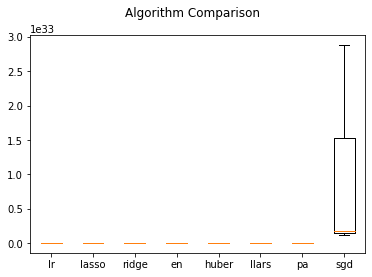

In [70]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [59]:
X_train[:5]

array([[1991, 872138730.8, 64622.0, 18.0, 18.0, 2.0, 2.0, 2.0, 0.0, 0.0,
        0.42, 15.58, 0.0, 0.42, 0.0, 0.0, 0.0, 764887117.2, 62149.0, 2.0,
        0.0, 0.42, 0.0, 0.0, 0.0, 0.0, 0.0, 0.038268701061558, 0.0, 0.0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1992, 958463200.2, 68235.0, 18.0, 18.0, 2.0, 2.0, 2.0, 0.0, 0.0,
        0.42, 15.58, 0.0, 0.42, 0.0, 0.0, 0.0, 872138730.8, 64622.0, 2.0,
        0.0, 0.42, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052949366161060996, 0.0,
        0.0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [1993, 1082979708.0, 72504.0, 18.0, 18.0, 2.0, 2.0, 2.0, 0.0, 0.0,
        0.42, 15.58, 0.0, 0.42, 0.0, 0.0, 0.0, 958463200.2, 68235.0, 2.0,
        0.0, 0.42, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0588795100959947, 0.0, 0.0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1994, 1245688253.0, 76700.0, 18.0, 18.0, 2.0, 2.0, 2.0, 0.0, 0.0,
        0.42, 15.58, 0.0, 0.

In [63]:
ycol

93

In [76]:
# non-linear models
models = []
models.append(('knn', KNeighborsRegressor(n_neighbors=7)))
models.append(('cart', DecisionTreeRegressor()))
models.append(('extra', ExtraTreeRegressor()))
models.append(('svmr', SVR()))
# # ensemble models
n_trees = 100
models.append(('ada', AdaBoostRegressor(n_estimators=n_trees)))
models.append(('bag',BaggingRegressor(n_estimators=n_trees)))
models.append(('rf', RandomForestRegressor(n_estimators=n_trees)))
models.append(('et', ExtraTreesRegressor(n_estimators=n_trees)))
models.append(('gbm',GradientBoostingRegressor(n_estimators=n_trees)))


array = df2.values

#start with trying the results from the second run of boruta + rest of cat vars
cols = ['yr', 'gdp', 'pop', 'x_6600_5110', 'x_6601_5110', 'x_6602_5110', 'x_6610_5110', 'x_6620_5110', 
               'x_6650_5110', 'x_6655_5110', 'x_6663_5110', 'x_6670_5110', 'x_6716_5110', 'x_6717_5110', 
               'x_1603_5516', 'x_1633_5516', 'x_1634_5516', 'lag_gdp', 'lag_pop', 'lag_x_6610_5110', 
               'lag_x_6716_5110', 'lag_x_6717_5110', 'lag_x_1603_5516', 'lag_x_1604_5516', 'lag_x_1623_5516', 
               'lag_x_1633_5516', 'lag_x_1634_5516', 'delta_pop', 'delta_x_6716_5110', 'delta_x_6717_5110', 
               'IncomeGroup.x_Lower middle income', 'Sub.Regions.x_Northern Africa', 'Sub.Regions.x_Polynesia', 
               'Sub.Regions.x_Sub-Saharan Africa','IncomeGroup.x_High income', 'IncomeGroup.x_Low income',
               'IncomeGroup.x_Lower middle income','IncomeGroup.x_Upper middle income',
               'Sub.Regions.x_Australia and New Zealand','Sub.Regions.x_Central Asia','Sub.Regions.x_Eastern Asia',
               'Sub.Regions.x_Eastern Europe','Sub.Regions.x_Latin America and the Caribbean',
               'Sub.Regions.x_Melanesia','Sub.Regions.x_Micronesia','Sub.Regions.x_Northern America',
               'Sub.Regions.x_Northern Europe','Sub.Regions.x_South-eastern Asia','Sub.Regions.x_Southern Asia',
               'Sub.Regions.x_Southern Europe','Sub.Regions.x_Western Asia','Sub.Regions.x_Western Europe']
xcols = [df2.columns.get_loc(c) for c in cols if c in df2]
ycol = df2.columns.get_loc('delta_forest_area')

X_train = array[:, xcols]
y = array[:, ycol]

results = []
names = []
scoring = 'neg_mean_squared_error'
for name, model in models:
    kfold = model_selection.KFold(n_splits=3, random_state=13)
    cv_results = model_selection.cross_val_score(model, X_train, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

knn: -0.000227 (0.000066)
cart: -0.000284 (0.000049)
extra: -0.000347 (0.000138)
svmr: -0.000463 (0.000032)


/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/kimberlyjanda/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


ada: -0.000165 (0.000036)
bag: -0.000120 (0.000027)
rf: -0.000120 (0.000027)
et: -0.000148 (0.000054)
gbm: -0.000131 (0.000026)


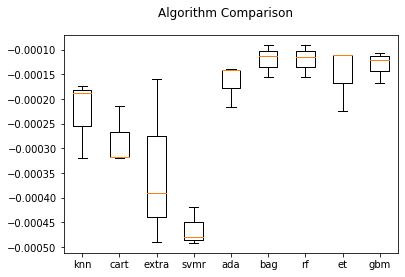

In [77]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()